### Disclaimer

The content provided on this platform is presented "as is" and is subject to copyright owned by Nilay Parikh (me@nilayparikh.com) and ErgoSum / X Labs. We make no warranties, express or implied, regarding the accuracy, completeness, or suitability of the information contained herein for any particular purpose.

While we strive to provide accurate and up-to-date information, we cannot guarantee the correctness or timeliness of the content. Any reliance you place on such information is strictly at your own risk.

You are granted permission to use, modify, and share this content for personal and non-commercial purposes, provided that proper attribution is given to Nilay Parikh and ErgoSum / X Labs as the copyright holders.

In no event shall Nilay Parikh, ErgoSum, X Labs, or any associated parties be liable for any damages arising out of the use or inability to use the information provided, even if they have been advised of the possibility of such damages.

This disclaimer serves as a legal notice and should be acknowledged and understood before accessing or using the content provided on this platform.

### Introduction

The optimization and experimentation described were conducted on Azure Kubernetes Services (AKS), a managed container orchestration platform provided by Microsoft Azure. AKS offers a scalable and flexible environment for deploying, managing, and optimizing containerized applications, making it an ideal choice for fine-tuning and enhancing the system's performance within a Kubernetes-based infrastructure on the Azure cloud platform.

The views expressed here are personal opinions, and there is no official data being presented or distributed. All the data mentioned was generated as part of a simulated dry run, replicating a real-world production environment. This data was created for the purpose of experimentation within the context of ErgoSum / X Labs and by individual researchers.

Refer to the YouTube video for Adaptive Autoscaling in Kubernetes for more information on the project and the results. https://youtu.be/O3HlpFc22CI 

#### Strategy
![aiops-Kubernetes AIOps.drawio.png](<attachment:aiops-Kubernetes AIOps.drawio.png>)

#### Data (.csv) File Format

```csv
ts,total_nodes,node_group_id,node_sku,max_cpu_on_node,min_cpu_on_node,avg_cpu_on_nodes,max_mem_on_node,min_mem_on_node,avg_mem_on_node,ord_api_v2_avg_res_time,brs_api_v2_avg_res_time,ff_avg_processing_time,dist_avg_processing_time,cost_per_node,reserved_nodes,reserved_cost_adjustment
2023-04-01 00:00:00,9,1,Standard_D8d_v4,80.47286498801027,6.5509584505328,29.944500513351603,54.765877255585494,23.30046986994824,25.13858456015072,291.42038265120937,321.7065308272321,1950.0186253879483,2261.636001194031,0.452,5,0.3
```
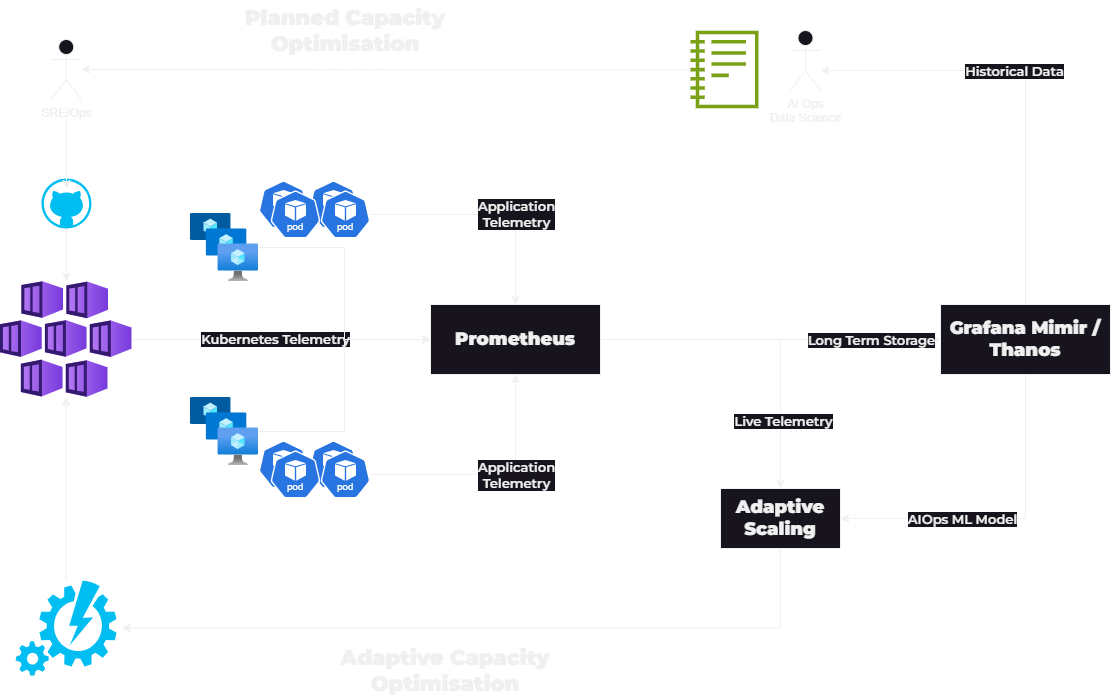

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

In [197]:
def draw(df_filter, title):

  # Calculate cost
  df_filter['cost'] = df_filter.apply(lambda row: row['reserved_nodes'] * row['cost_per_node'] * row['reserved_cost_adjustment'] + (row['total_nodes'] - row['reserved_nodes']) * row['cost_per_node'] if row['total_nodes'] > row['reserved_nodes'] else row['total_nodes'] * row['cost_per_node'] * row['reserved_cost_adjustment'], axis=1)

  fig = plt.figure(figsize=(20, 15))
  gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1])

  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax2 = plt.subplot(gs[2])
  ax3 = plt.subplot(gs[3])

  ax0.set_title(title)

  # Calculate the 65th percentile of the 'max_cpu_on_node' data
  percentile_65 = df_filter['max_cpu_on_node'].quantile(0.65)
  ax0.axhline(y=percentile_65, color='r', linestyle='--', label='65th percentile')
  ax0.text(df_filter.index[-1], percentile_65, '65th percentile: {:.2f}'.format(percentile_65), va='bottom', ha='right', color='r')

  # Calculate the 35th percentile of the 'max_cpu_on_node' data
  percentile_35 = df_filter['max_cpu_on_node'].quantile(0.35)
  ax0.axhline(y=percentile_35, color='g', linestyle='--', label='35th percentile')
  ax0.text(df_filter.index[-1], percentile_35, '35th percentile: {:.2f}'.format(percentile_35), va='bottom', ha='right', color='g')

  # Continue with your plotting code...
  ax0.plot(df_filter.index, df_filter['max_cpu_on_node'], label='Max CPU on Node', alpha=0.4)
  ax0.plot(df_filter.index, df_filter['min_cpu_on_node'], label='Min CPU on Node', alpha=0.4)
  ax0.plot(df_filter.index, df_filter['avg_cpu_on_nodes'], label='Avg CPU on Nodes')

  # Set the y-axis label for the first subplot
  ax0.set_ylabel('CPU Usage')

  # Add a line plot for the 'total_nodes' data in the second subplot
  ax1.plot(df_filter.index, df_filter['total_nodes'], label='Total Nodes', color='k', linewidth=2, linestyle='-.')

  # Calculate min, max, and average of the 'total_nodes' data
  min_total_nodes = df_filter['total_nodes'].min()
  max_total_nodes = df_filter['total_nodes'].max()
  avg_total_nodes = df_filter['total_nodes'].mean()

  # Add horizontal lines at min, max, and average in the second subplot
  ax1.axhline(y=min_total_nodes, color='b', linestyle='--', label='Min Total Nodes')
  ax1.axhline(y=max_total_nodes, color='r', linestyle='--', label='Max Total Nodes')
  ax1.axhline(y=avg_total_nodes, color='g', linestyle='--', label='Avg Total Nodes')

  # Add text at min, max, and average in the second subplot
  ax1.text(df_filter.index[0], min_total_nodes, 'Min: {:.2f}'.format(min_total_nodes), va='bottom', ha='right', color='b')
  ax1.text(df_filter.index[0], max_total_nodes, 'Max: {:.2f}'.format(max_total_nodes), va='bottom', ha='right', color='r')
  ax1.text(df_filter.index[0], avg_total_nodes, 'Avg: {:.2f}'.format(avg_total_nodes), va='bottom', ha='right', color='g')

  # Set the x-axis, y-axis label for the second subplot
  ax1.set_xlabel('Day of the Week')
  ax1.set_ylabel('Total Nodes')

  # Format x-axis to show dates in 'Day' format
  ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %A'))
  ax1.xaxis.set_major_locator(mdates.DayLocator())
  
  # Add line plots for the new data in the third subplot
  ax2.plot(df_filter.index, df_filter['ord_api_v2_avg_res_time'], label='ORD API v2 Avg Response Time', alpha=0.2)
  ax2.plot(df_filter.index, df_filter['brs_api_v2_avg_res_time'], label='BRS API v2 Avg Response Time', alpha=0.2)
  ax2.plot(df_filter.index, df_filter['ff_avg_processing_time'], label='FF Avg Processing Time', alpha=0.2)
  ax2.plot(df_filter.index, df_filter['dist_avg_processing_time'], label='Dist Avg Processing Time', alpha=0.2)

  # Calculate the 95th percentile for each series
  percentile_95_ord = df_filter['ord_api_v2_avg_res_time'].quantile(0.95)
  percentile_95_brs = df_filter['brs_api_v2_avg_res_time'].quantile(0.95)
  percentile_95_ff = df_filter['ff_avg_processing_time'].quantile(0.95)
  percentile_95_dist = df_filter['dist_avg_processing_time'].quantile(0.95)

  # Add horizontal lines at the 95th percentile for each series
  ax2.axhline(y=percentile_95_ord, color='b', linestyle='--', label='95th percentile ORD')
  ax2.axhline(y=percentile_95_brs, color='r', linestyle='--', label='95th percentile BRS')
  ax2.axhline(y=percentile_95_ff, color='g', linestyle='--', label='95th percentile FF')
  ax2.axhline(y=percentile_95_dist, color='y', linestyle='--', label='95th percentile Dist')

  # Add text at the 95th percentile for each series
  ax2.text(df_filter.index[-1], percentile_95_ord, '95th percentile ORD: {:.2f}'.format(percentile_95_ord), va='bottom', ha='right', color='b')
  ax2.text(df_filter.index[-1], percentile_95_brs, '95th percentile BRS: {:.2f}'.format(percentile_95_brs), va='bottom', ha='right', color='r')
  ax2.text(df_filter.index[-1], percentile_95_ff, '95th percentile FF: {:.2f}'.format(percentile_95_ff), va='bottom', ha='right', color='g')
  ax2.text(df_filter.index[-1], percentile_95_dist, '95th percentile Dist: {:.2f}'.format(percentile_95_dist), va='bottom', ha='right', color='y')

  # Set the x-axis, y-axis label for the third subplot
  ax2.set_xlabel('Day of the Week')
  ax2.set_ylabel('QoS Metrics')

  # Format x-axis to show dates in 'Day' format
  ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %A'))
  ax2.xaxis.set_major_locator(mdates.DayLocator())

  # Plot the cost data
  ax3.plot(df_filter.index, df_filter['cost'], label='Cost', color='m', linewidth=2)

  # Calculate total cost
  total_cost = df_filter['cost'].sum() / 12 # 5 min bars, 12 bars per hour
  total_hours = (df_filter.index[-1] - df_filter.index[0]).total_seconds() / 3600
  average_cost_per_hour = total_cost / total_hours

  # Plot the cost data
  ax3.plot(df_filter.index, df_filter['cost'], label='Cost', color='m', linewidth=2)

  # Add a horizontal line for the average cost per hour
  ax3.axhline(y=average_cost_per_hour, color='k', linestyle='--', label='Average Cost per Hour')
  ax3.text(df_filter.index[0], average_cost_per_hour, 'Average Cost per Hour: {:.2f}'.format(average_cost_per_hour), va='bottom')

  # Set the x-axis, y-axis label for the new subplot
  ax3.set_xlabel('Day of the Week')
  ax3.set_ylabel('Cost per Hour')

  # Format x-axis to show dates in 'Day' format
  ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %A'))
  ax3.xaxis.set_major_locator(mdates.DayLocator())

  # ax0.legend()
  # ax1.legend()
  # ax2.legend()

  plt.show()

  qos_percentiles_df = pd.DataFrame({
    'ORD API v2 Avg Response Time': [percentile_95_ord],
    'BRS API v2 Avg Response Time': [percentile_95_brs],
    'FF Avg Processing Time': [percentile_95_ff],
    'Dist Avg Processing Time': [percentile_95_dist],
    'Cost per Hour': [average_cost_per_hour]
  })

  # # Display the DataFrame
  # display(qos_percentiles_df)

  return qos_percentiles_df

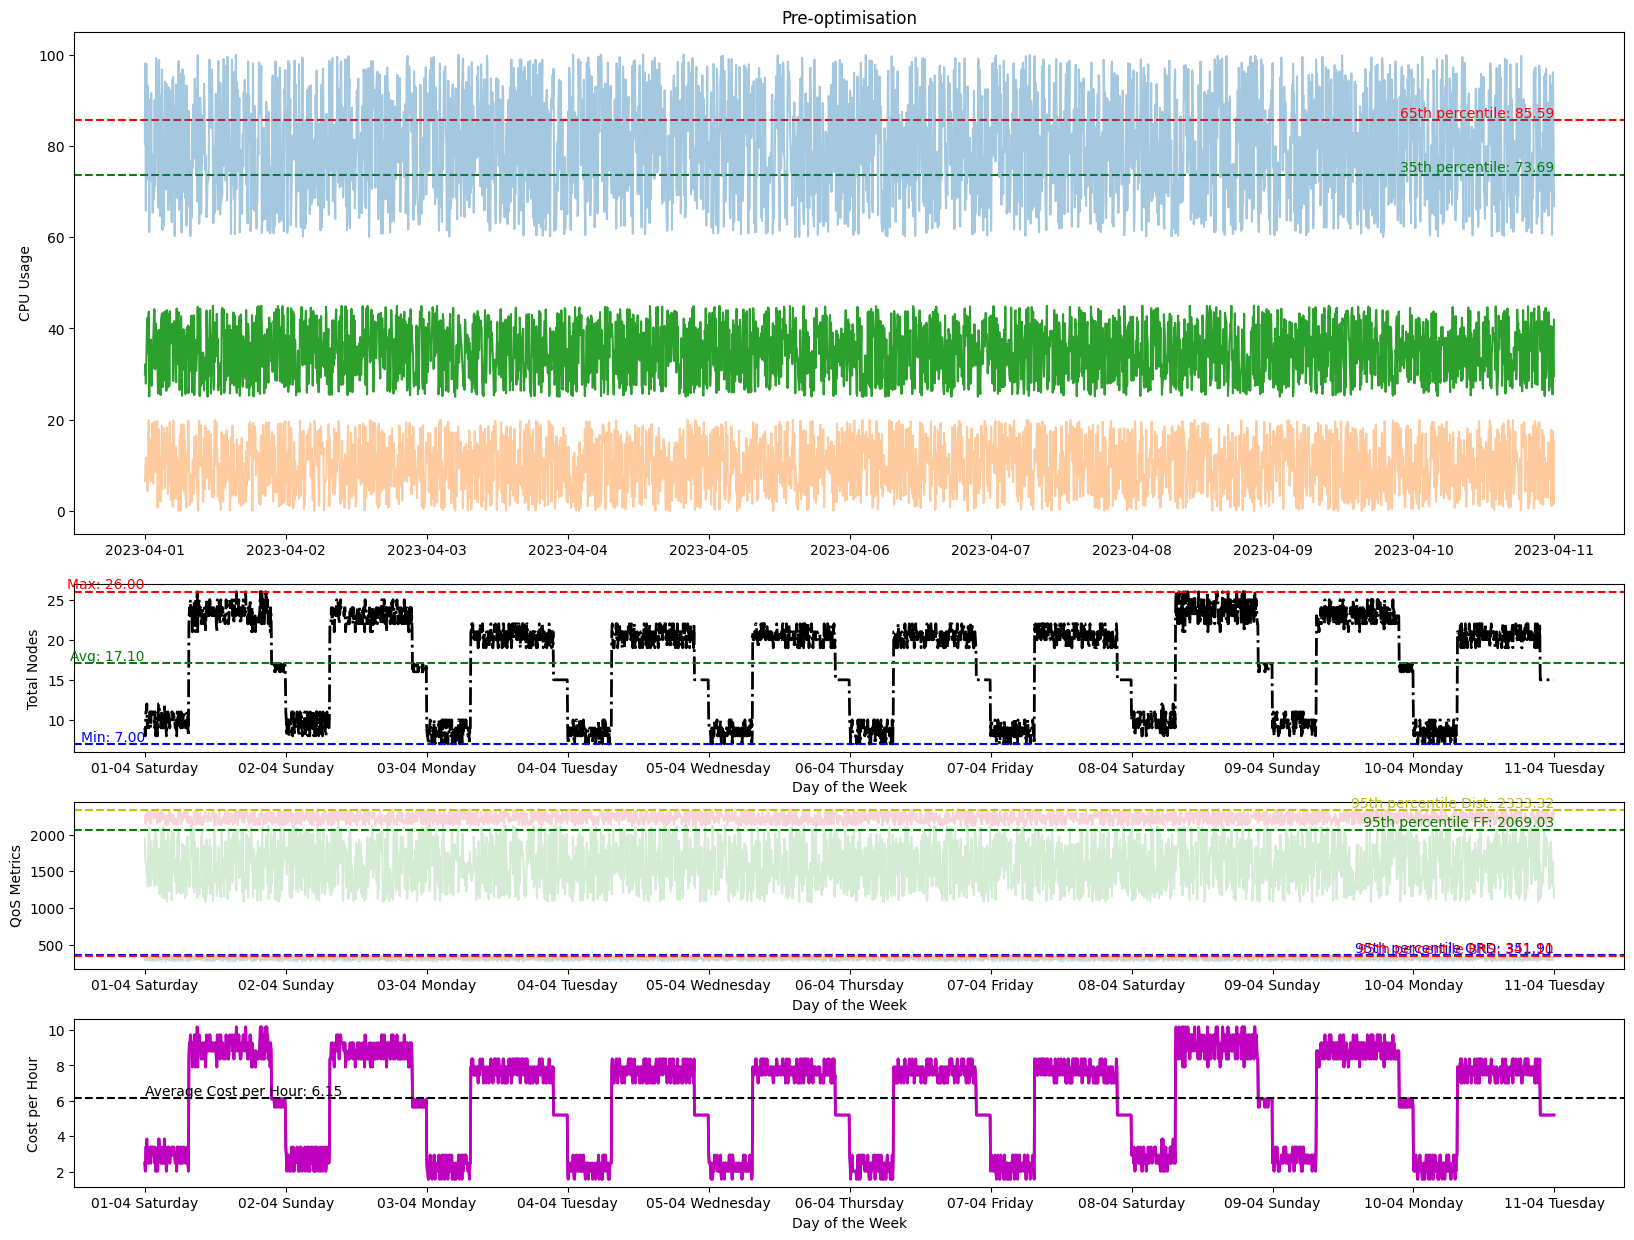

In [198]:
df = pd.read_csv('/home/nilayparikh/.sources/ergosum/x/esx/forecast/data/data_v1.csv')
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

# Filter the data for a specific week
df_filter = df.loc['2023-4-1':'2023-4-10'].copy()
pre_optimisation_qos_percentiles_df = draw(df_filter, 'Pre-optimisation')

### First Optimisation

The first optimization phase involves streamlining the network architecture by reducing the number of nodes and revising the scaling criteria in accordance with the insights gained from the previous research or analysis. This process aims to enhance system efficiency and performance by making the network structure more concise and adaptable to the specific patterns or requirements identified during the initial investigation.

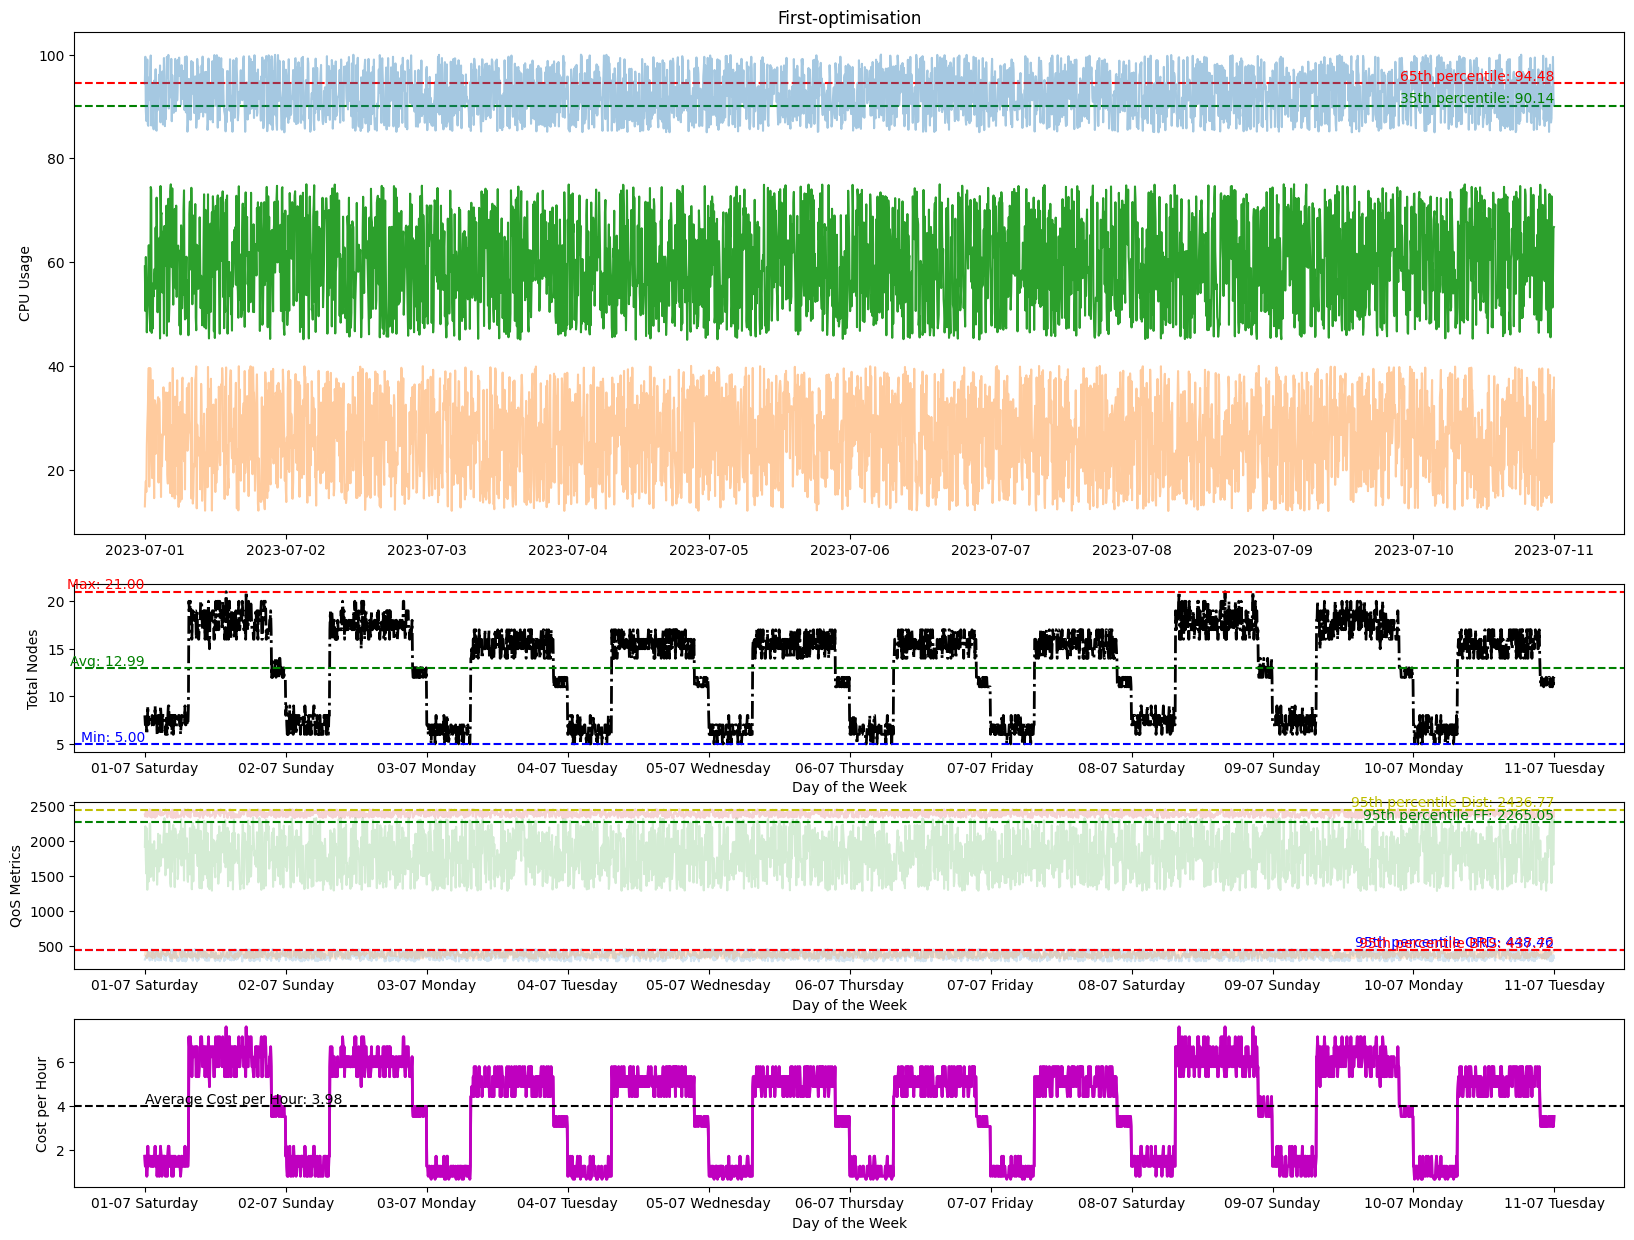

In [199]:
df = pd.read_csv('/home/nilayparikh/.sources/ergosum/x/esx/forecast/data/data_v2.csv')
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

# Filter the data for a specific week
df_filter = df.loc['2023-7-1':'2023-7-10'].copy()
first_optimisation_qos_percentiles_df = draw(df_filter, 'First-optimisation')

### Second Optimisation

In the second optimization phase, we implement adaptive scaling through the use of machine learning and automation techniques. This means that the system can dynamically adjust its resources based on real-time demands and workload patterns, optimizing resource allocation for efficiency. Additionally, we upgrade the scaling nodes from `Standard_D8d_v4` to the more powerful `Standard_D16d_v4` to meet increased computational requirements. Moreover, we introduce smaller liquid clusters, particularly `Standard_D4d_v4`, to create a more agile and adaptable infrastructure that can efficiently handle varying workloads. This combination of adaptability and resource enhancement helps improve overall system performance and responsiveness.

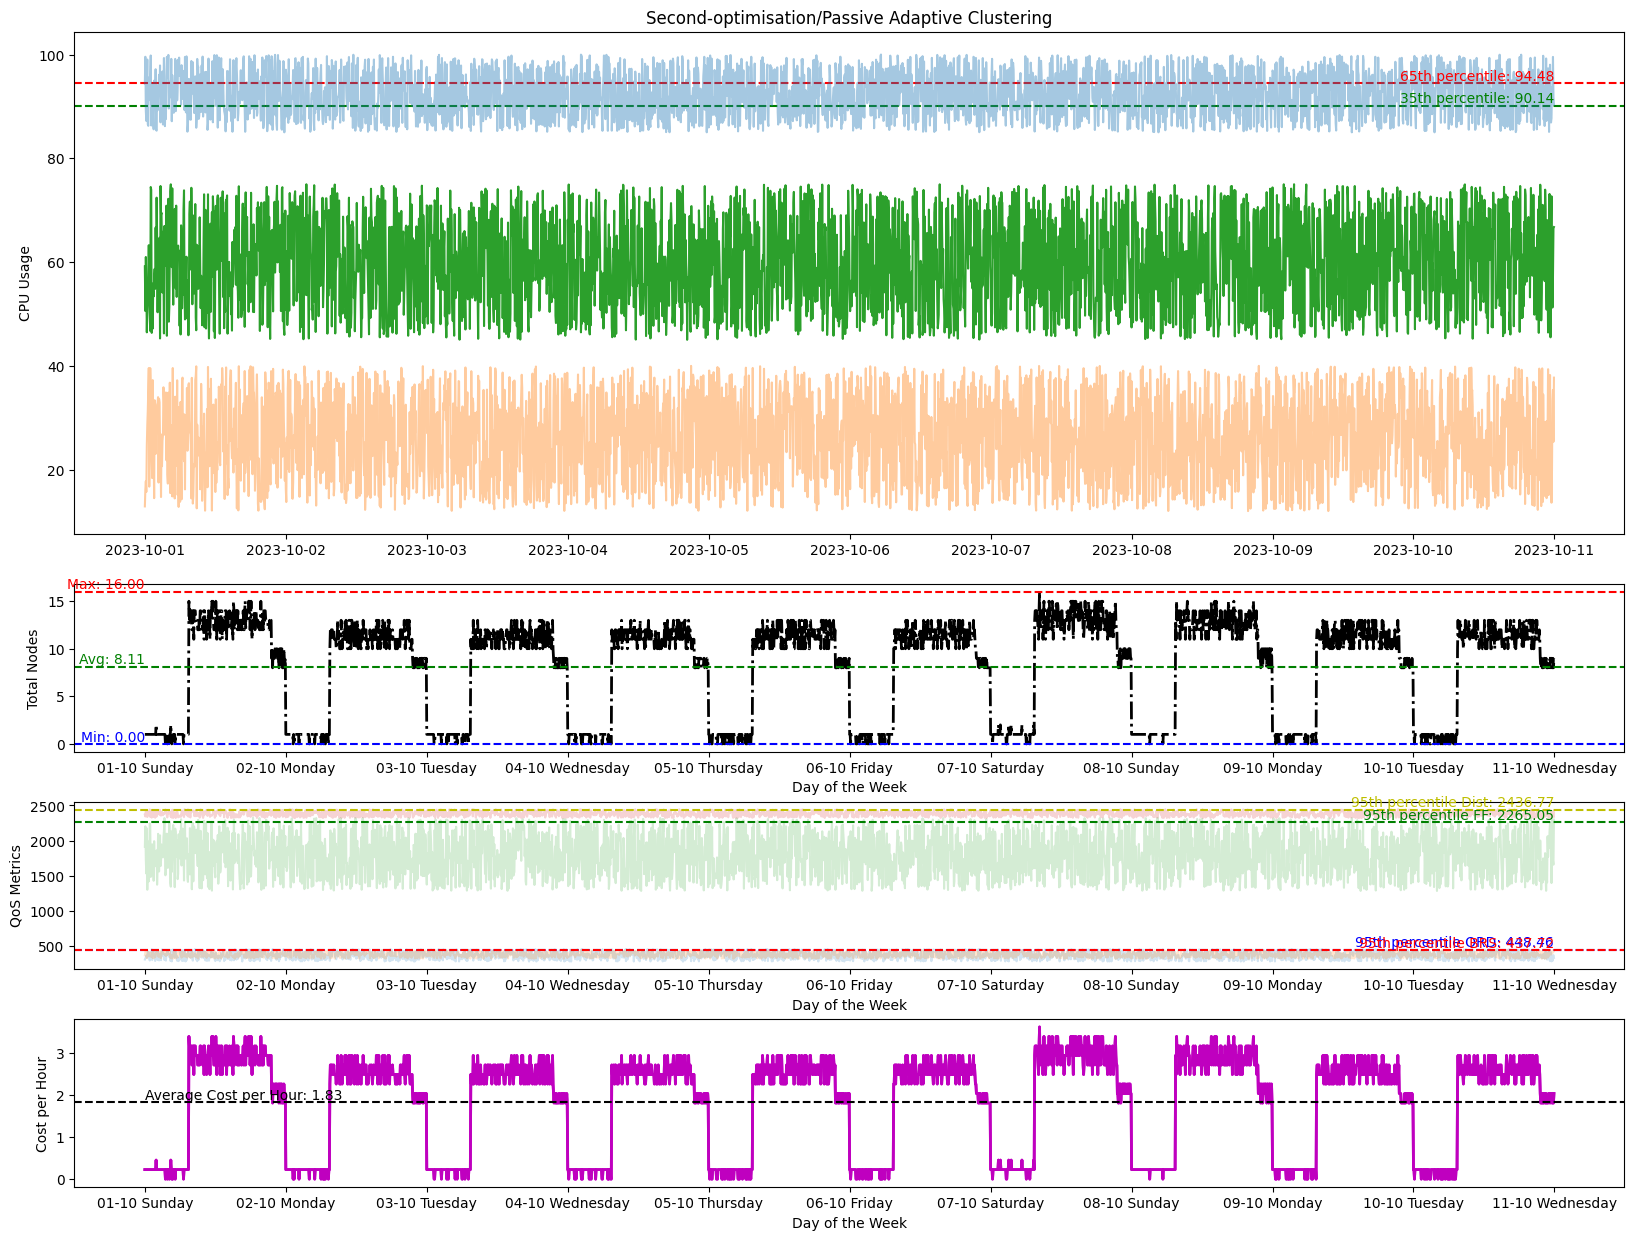

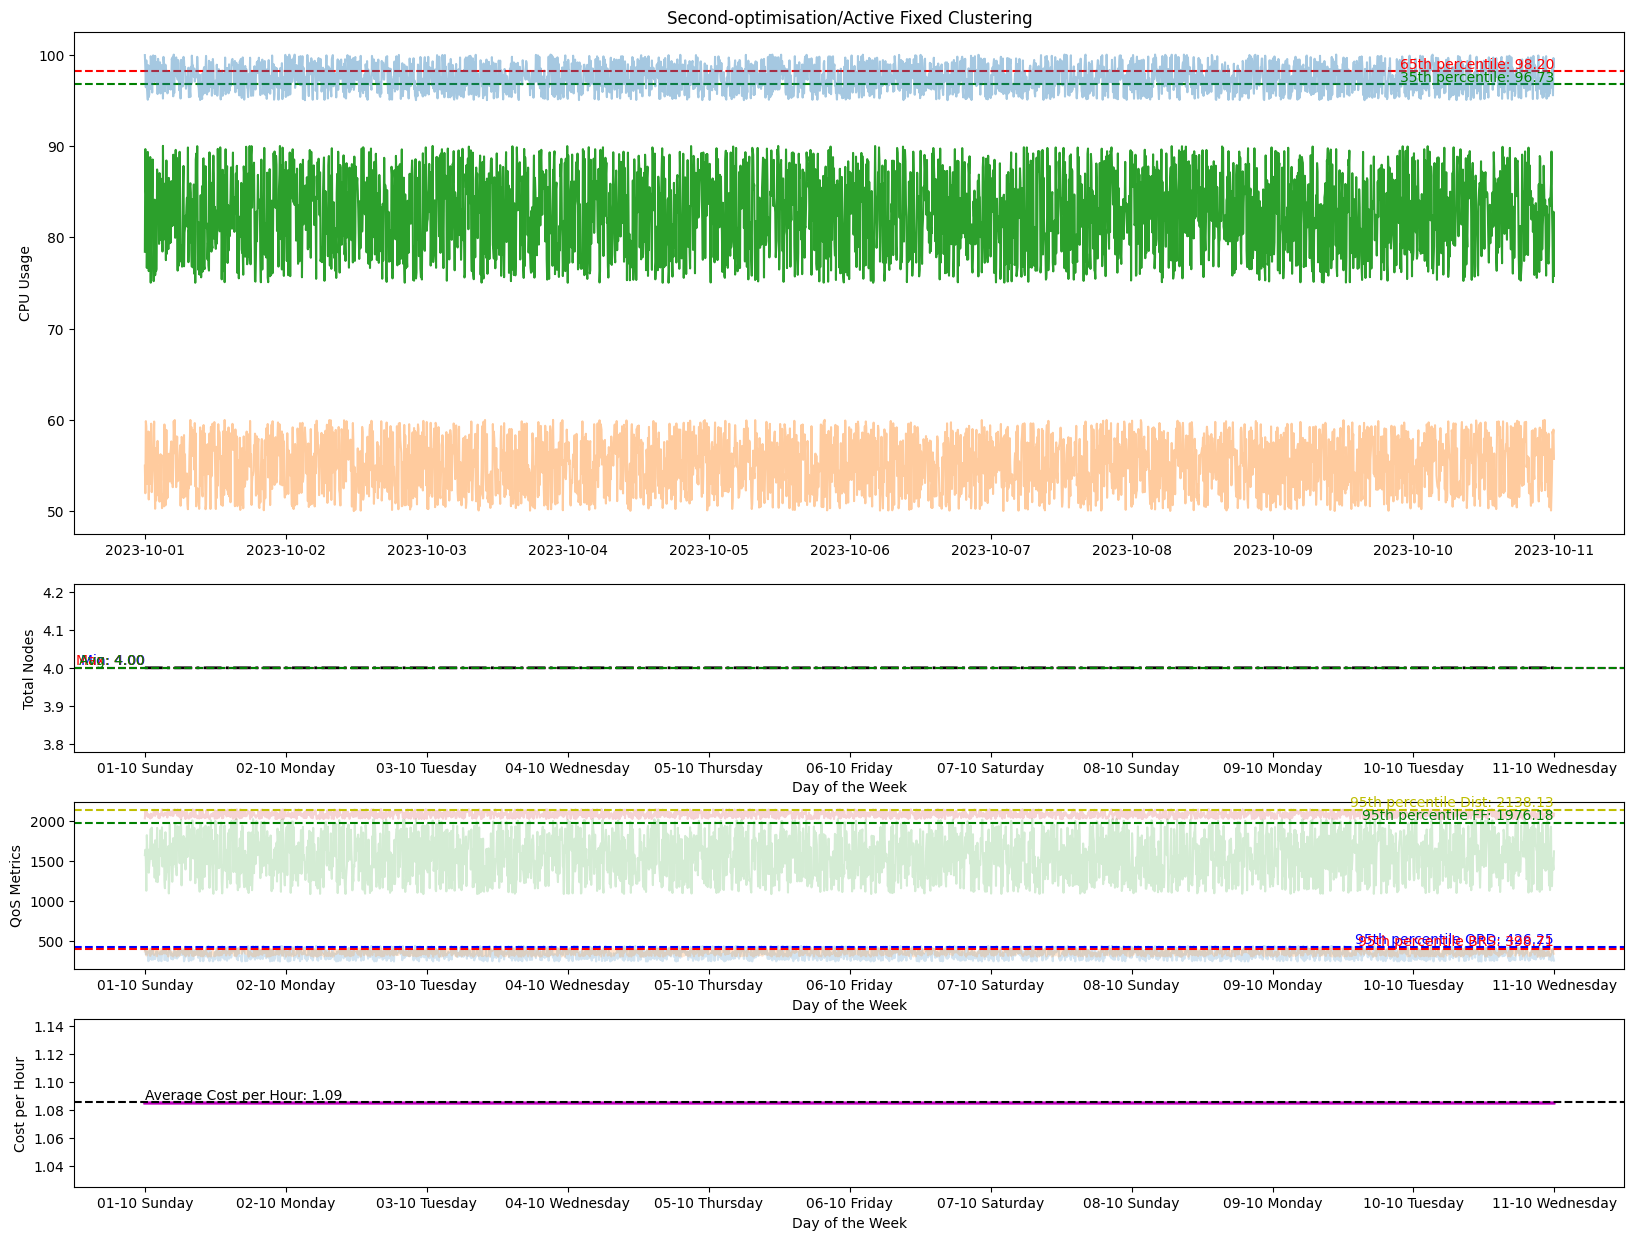

In [200]:
df_1 = pd.read_csv('/home/nilayparikh/.sources/ergosum/x/esx/forecast/data/data_v3_1.csv')
df_1['ts'] = pd.to_datetime(df_1['ts'])
df_1.set_index('ts', inplace=True)

# Filter the data for a specific week
df_filter_1 = df_1.loc['2023-10-1':'2023-10-10'].copy()
second_optimisation_qos_percentiles_df_1 = draw(df_filter_1, 'Second-optimisation/Passive Adaptive Clustering')

df_2 = pd.read_csv('/home/nilayparikh/.sources/ergosum/x/esx/forecast/data/data_v3_2.csv')
df_2['ts'] = pd.to_datetime(df_2['ts'])
df_2.set_index('ts', inplace=True)

# Filter the data for a specific week
df_filter_2 = df_2.loc['2023-10-1':'2023-10-10'].copy()
second_optimisation_qos_percentiles_df_2 = draw(df_filter_2, 'Second-optimisation/Active Fixed Clustering')

# Combine the two DataFrames
combined_df = pd.concat([second_optimisation_qos_percentiles_df_1, second_optimisation_qos_percentiles_df_2])

# Calculate the average for all columns except "Cost per Hour"
average_df = combined_df.drop(columns=["Cost per Hour"]).mean()

# Calculate the sum for the "Cost per Hour" column
sum_cost_per_hour = combined_df["Cost per Hour"].sum()

# Combine the average and sum into a single DataFrame
result_df = pd.DataFrame(pd.concat([average_df, pd.Series({"Cost per Hour": sum_cost_per_hour})]))

# Transpose the DataFrame to match the original structure
second_optimisation_qos_percentiles_df = result_df.T

In [201]:
# Concatenate all qos_percentiles DataFrames along the columns axis
comparison_df = pd.concat([pre_optimisation_qos_percentiles_df, first_optimisation_qos_percentiles_df, second_optimisation_qos_percentiles_df]).T

# Rename the columns for clarity
comparison_df.columns = ['Pre-Optimisation', 'First-Optimisation', 'Second-Optimisation']

# Calculate the Cost per Month and add it as a new row
comparison_df.loc['Cost per Month'] = comparison_df.loc['Cost per Hour'] * 735

display(comparison_df)

,Pre-Optimisation,First-Optimisation,Second-Optimisation
ORD API v2 Avg Response Time,351.906735,448.459932,437.353275
BRS API v2 Avg Response Time,341.100428,437.719951,418.217111
FF Avg Processing Time,2069.031653,2265.049194,2120.612328
Dist Avg Processing Time,2333.322671,2436.765247,2287.448618
Cost per Hour,6.150905,3.978997,2.918768
Cost per Month,4520.915304,2924.563009,2145.294206


In [205]:
# Calculate the percentage difference between the first optimisation and pre-optimisation
comparison_df['First-Optimisation Improvement (%)'] = ((comparison_df['First-Optimisation'] - comparison_df['Pre-Optimisation']) / comparison_df['Pre-Optimisation']) * 100

# Calculate the percentage difference between the second optimisation and pre-optimisation
comparison_df['Second-Optimisation Improvement (%)'] = ((comparison_df['Second-Optimisation'] - comparison_df['Pre-Optimisation']) / comparison_df['Pre-Optimisation']) * 100

# Display the comparison DataFrame
display(comparison_df)

,Pre-Optimisation,First-Optimisation,Second-Optimisation,First-Optimisation Improvement (%),Second-Optimisation Improvement (%)
ORD API v2 Avg Response Time,351.906735,448.459932,437.353275,27.437155,24.281019
BRS API v2 Avg Response Time,341.100428,437.719951,418.217111,28.325829,22.608205
FF Avg Processing Time,2069.031653,2265.049194,2120.612328,9.473878,2.492986
Dist Avg Processing Time,2333.322671,2436.765247,2287.448618,4.433274,-1.966040
Cost per Hour,6.150905,3.978997,2.918768,-35.310378,-52.547348
Cost per Month,4520.915304,2924.563009,2145.294206,-35.310378,-52.547348
